# 1. Import

In [458]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from matplotlib import pyplot as plt

from pathlib import Path
from tqdm import tqdm
import datetime

# 2. Load Data

In [459]:
# load daily industry returns
df_daily = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios_Daily.CSV", index_col = 0)
df_daily.index = pd.to_datetime(df_daily.index, format = "%Y%m%d")
df_daily = df_daily / 100

# handle NA values
mask = (df_daily <= -0.99)
df_daily[mask] = np.nan

In [460]:
# load Fama French 3 Daily Factors
ff = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors_daily.CSV", index_col = 0)
ff.index = pd.to_datetime(ff.index, format = "%Y%m%d")
ff = ff / 100

# load Fama French 3 Monthly Factors
ff_monthly = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0)
ff_monthly.index = pd.to_datetime(ff_monthly.index, format = "%Y%m")
ff_monthly = ff_monthly / 100


# load 4 Monthly Fama French Factors (Mkt-RF, SMB, HML, MOM) and construct FF4 model
ff4 = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_Factors.CSV", index_col = 0)
ff4.index = pd.to_datetime(ff4.index, format = "%Y%m")
ff4 = ff4 / 100

ff4_mom = pd.read_csv(str(Path().absolute()) + "/data/F-F_Momentum_Factor.CSV", index_col = 0)
ff4_mom.index = pd.to_datetime(ff4_mom.index, format = "%Y%m")
ff4_mom = ff4_mom / 100
ff4 = pd.concat([ff4, ff4_mom], axis = 1)
ff4 = ff4.dropna()


# load Fama French 5 Daily Factors
ff5 = pd.read_csv(str(Path().absolute()) + "/data/F-F_Research_Data_5_Factors_2x3.csv", index_col = 0)
ff5.index = pd.to_datetime(ff5.index, format = "%Y%m")
ff5 = ff5 / 100

In [483]:
# industry returns
df = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 11, nrows = 1182, header=0)
df.index = pd.to_datetime(df.index, format = "%Y%m")
df = df / 100

# remove NAs
mask = (df <= -0.99)
df[mask] = np.nan

# nb of industries dataframe
nb_industries = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 2587, nrows = 1182, header=0)
nb_industries.index = pd.to_datetime(nb_industries.index, format = "%Y%m")
mask = (nb_industries <= -0.99)
nb_industries[mask] = np.nan

# average sizes dataframe
avg_size = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 3773, nrows = 1182, header=0)
avg_size.index = pd.to_datetime(avg_size.index, format = "%Y%m")
mask = (avg_size <= -0.99)
avg_size[mask] = np.nan

# sum of BE / sum of ME dataframe
be_over_me = pd.read_csv(str(Path().absolute()) + "/data/48_Industry_Portfolios.CSV", index_col = 0, skiprows = 4959, nrows = 99, header=0)
be_over_me.index = pd.to_datetime(be_over_me.index, format = "%Y")


# 3. Calculate Characteristics

## 3.1 Market Cap, Book-to-Market, Momentum

In [484]:
# market cap of each industry over time
mkt_cap = nb_industries * avg_size

# momentum with monthly data
momentum = df.rolling(12).mean()

# book value to market value
# resample be_over_me to monthly data
# we must first shift years since our "factor year" begins in July preventing us from grouping by years
be_over_me.index = be_over_me.index + pd.DateOffset(months = 6)
be_over_me = be_over_me.resample("MS").ffill()

# need to add missing portion of 2024 since data with shifted index is missing it
extra_be_over_me = pd.DataFrame(np.repeat([be_over_me.iloc[-1].values], repeats = 5, axis = 0), 
                                index = pd.date_range(start=be_over_me.index[-1] + pd.DateOffset(months = 1), end='2024-12-01', freq='MS'), 
                                columns = be_over_me.columns)

be_over_me = pd.concat([be_over_me, extra_be_over_me], axis = 0)
mask = (be_over_me <= -99.99)
be_over_me[mask] = np.nan

## 3.2 Beta

In [395]:
indices = pd.date_range("1926-07-30", "2024-12-31", freq = "M")
betas = pd.DataFrame(index=indices, columns=df_daily.columns)

for industry, industry_timeseries in tqdm(df_daily.items()):
    # skip first 12 months since we need a 12 month lookback window
    for i in range(12, len(indices)):
        
        # start and end date
        # this ensures ranges of following form for example: Sep 1 to Aug 31 
        start = indices[i-12] + pd.Timedelta(days = 1)
        end = indices[i]
        
        X = ff.loc[start:end,["Mkt-RF"]]
        y = industry_timeseries.loc[start:end] - ff.loc[start:end, "RF"]
        
        X = sm.add_constant(X)
        model = sm.OLS(y, X, missing='none').fit()
        beta = model.params["Mkt-RF"]
        
        # print(model.mse_resid)
        #try:
        #    beta = LinearRegression(fit_intercept=True).fit(X, y).coef_[0]
        #except ValueError:
        #    beta = np.nan
        
        betas.loc[end, industry] = beta
    
# convert the indices from month ends to starts of months
betas = betas.resample("MS").last()

48it [01:35,  1.99s/it]


## 3.3 Idiosyncratic Risk

In [396]:
# Get unique year-month pairs
monthly_periods = df_daily.resample('MS').mean().index

risk = pd.DataFrame(index=monthly_periods, columns=df_daily.columns)

for date in tqdm(monthly_periods):
    # Filter data for the entire month
    mask = (df_daily.index.year == date.year) & (df_daily.index.month == date.month)
    ret_data = df_daily[mask]
    factors_data = ff[mask]
    
    for industry, industry_timeseries in ret_data.items():
            
            # Ensure aligned data
            aligned_data = pd.concat([industry_timeseries, factors_data], axis = 1)
            
            X = aligned_data.loc[:,["Mkt-RF", "SMB", "HML"]].values
            y = (aligned_data.loc[:, industry] - aligned_data.loc[:, "RF"]).values
            
            X = sm.add_constant(X)
            model = sm.OLS(y, X, missing='none').fit()
            # try:
            #    reg = LinearRegression(fit_intercept=True).fit(X, y)
            #    resid = y - reg.predict(X)
            # except ValueError:
            #    resid = np.nan
            risk.loc[date, industry] = np.sqrt(model.mse_resid)
            

100%|██████████| 1182/1182 [01:04<00:00, 18.42it/s]


## 3.4 Long-Short Portfolios

In [399]:
def position(df: pd.DataFrame, n_assets: int):
    """
    Ranks assets by given characteristic and then determines the top n_assets and bottom n_assets to create long short portfolio
    ---
    :param df: dataframe of characteristics
    :param n_assets: number of assets to long and to short 
    :return: pandas DataFrame of positions of the long-short portfolio at each timestep
    """

    # in the case of ties, we need to arbitrarily pick an asset
    # otherwise, due to the way the "rank" function is written, we'd pick 4 instead of 5 assets 
    ranks = df.rank(ascending = False, method = "first", axis = 1)
    df_pos = pd.DataFrame(0, index = ranks.index, columns = ranks.columns)

    # longs
    df_pos[ranks <= n_assets] = 1

    # shorts
    # due to NAs, we can't simply pick assets from 48 to 48 - n_assets
    # we find the last rank and then pick the 5 ranks right below it
    threshold = (ranks.max(axis = 1) - n_assets)
    mask = ranks.gt(threshold, axis = 0)
    df_pos[mask] = -1

    return df_pos

In [400]:
def equal_weight_rets(df: pd.DataFrame, position: pd.DataFrame, n_longs: int):
    """
    calculates the returns of the equal weight long short portfolio 
    ---
    :param df: dataframe of underlying asset returns
    :param position: dataframe of positions at each timestep (usually the output of the position function)
    :param n_longs: number of long assets in the long-short portfolio
    :return: pandas DataFrame of returns of the equal-weighted long-short portfolio
    """
    
    # shift returns to account for lookahead bias
    performance = ((df * position.shift(1)) / n_longs).sum(axis = 1)
    return performance


def value_weights_rets(df, position, mkt_cap):
    """
    calculates the returns of the value weighted long short portfolio 
    ---
    :param df: dataframe of underlying asset returns
    :param position: dataframe of positions at each timestep (usually the output of the position function)
    :param mkt_cap: market cap of each industry in the universe
    :return: pandas DataFrame of returns of the value-weighted long-short portfolio
    """
    # long and short market weighted weights
    long_weights = mkt_cap[position == 1].div(mkt_cap[position == 1].sum(axis = 1), axis = 0)
    short_weights = mkt_cap[position == -1].div(mkt_cap[position == -1].sum(axis = 1), axis = 0)
    
    # returns of long-short portfolio
    # shift returns to account for lookahead bias
    long_portfolio = (df * long_weights.shift(1)).fillna(0)
    short_portfolio = (df * short_weights.shift(1)).fillna(0)
    performance = (long_portfolio - short_portfolio).sum(axis = 1)
    
    return performance

In [401]:
# long-short portfolio positions
pos_mkt_cap = position(mkt_cap, 5)
pos_be_over_me = position(be_over_me, 5)
pos_mom = position(momentum, 5)
pos_betas = position(betas, 5)
pos_risks = position(risk, 5)

# 4. Annualized Performance Measures

In [402]:
def mean_return(rets: pd.DataFrame):
    """
    calculates the annualized mean return of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :return: float of the annualized mean return
    """
    avg_ret = 12 * rets.mean()

    return avg_ret


def sharpe_ratio(rets: pd.DataFrame, rf: pd.DataFrame):
    """
    calculates the annualized sharpe ratio of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :param rf: pandas Series/DataFrame of risk-free rate
    :return: float of the annualized sharpe ratio
    """

    sharpe = np.sqrt(12) * (rets - rf).mean() / rets.std()  # use excess returns
    return sharpe


def alpha(rets: pd.DataFrame, ff: pd.DataFrame):
    """
    calculates the annualizedJensen's Alpha by OLS regression of a series of monthly returns
    ---
    :param rets: pandas Series/DataFrame of returns
    :param ff: pandas DataFrame of Fama French factors
    :return: float of the annualized sharpe ratio
    """

    ff = ff.values
    ff = sm.add_constant(ff)
    model = sm.OLS(rets, ff, missing='none').fit()
    
    return 12 * model.params["const"]

In [403]:
# equal weight returns
rets_mkt = equal_weight_rets(df, pos_mkt_cap, 5)
rets_be_me = equal_weight_rets(df, pos_be_over_me, 5)
rets_mom = equal_weight_rets(df, pos_mom, 5)
rets_betas = equal_weight_rets(df, pos_betas, 5)
rets_risks = equal_weight_rets(df, pos_risks, 5)

equal_weight_results = pd.DataFrame({"EW_Mkt": rets_mkt, 
                                     "EW_BE_ME": rets_be_me, 
                                     "EW_Momentum": rets_mom, 
                                     "EW_Beta": rets_betas, 
                                     "EW_Risks": rets_risks}, 
                                     index = rets_mkt.index)

# value weighted returns
rets_mkt = value_weights_rets(df, pos_mkt_cap, mkt_cap)
rets_be_me = value_weights_rets(df, pos_be_over_me, mkt_cap)
rets_mom = value_weights_rets(df, pos_mom, mkt_cap)
rets_betas = value_weights_rets(df, pos_betas, mkt_cap)
rets_risks = value_weights_rets(df, pos_risks, mkt_cap)

value_weights_results = pd.DataFrame({"Val_Mkt": rets_mkt, 
                                      "Val_BE_ME": rets_be_me, 
                                      "Val_Momentum": rets_mom, 
                                      "Val_Beta": rets_betas, 
                                      "Val_Risks": rets_risks}, 
                                      index = rets_mkt.index)

portfolio_results = pd.concat([equal_weight_results, value_weights_results], axis = 1)

In [408]:
# we will long all strategies which had a negative outcome
# this includes:
# 1. long short market cap (value and equal weight)
# 2. long short Beta (value and equal weight)
# 3. long short idiosyncratic risk (value and equal weight)

portfolio_results.loc[:, ["EW_Mkt", "EW_Beta", "EW_Risks", "Val_Mkt", "Val_Beta", "Val_Risks"]] = -1 * portfolio_results.loc[:, ["EW_Mkt", "EW_Beta", "EW_Risks", "Val_Mkt", "Val_Beta", "Val_Risks"]]

In [409]:
start_year = [1950, 1990, 2000]
results = [np.nan, np.nan, np.nan]

for i in range(len(start_year)):
    
    start = start_year[i]
    # select current period for returns
    mask = portfolio_results.index.year >= start
    current_portfolio = portfolio_results[mask]
    
    # select current period for alpha
    current_ff3 = ff_monthly.loc[ff_monthly.index.year >= start, ["Mkt-RF", "SMB", "HML"]]
    current_ff4 = ff4.loc[ff4.index.year >= start, ["Mkt-RF", "SMB", "HML", "Mom   "]]
    current_ff5 = ff5.loc[ff5.index.year >= max(start, 1964), ["Mkt-RF", "SMB", "RMW", "CMA"]]
    
    mean_rets= current_portfolio.apply(mean_return, axis = 0)
    sharpe_ratios = current_portfolio.apply(lambda x: sharpe_ratio(x, ff["RF"]), axis = 0)
    alpha_ff3 = current_portfolio.apply(lambda x: alpha(x, current_ff3[["Mkt-RF", "SMB", "HML"]]), axis = 0)
    alpha_ff4 = current_portfolio.apply(lambda x: alpha(x, current_ff4[["Mkt-RF", "SMB", "HML", "Mom   "]]), axis = 0)
    alpha_ff5 = current_portfolio.loc[current_portfolio.index.year >= 1964].apply(lambda x: alpha(x, current_ff5[["Mkt-RF", "SMB", "RMW", "CMA"]]), axis = 0)
    
    results[i] = pd.concat([mean_rets, sharpe_ratios, alpha_ff3, alpha_ff4, alpha_ff5], axis = 1)
    results[i].columns = ["Mean Return", "Sharpe Ratio", "Alpha 3 Factor Fama French", "Alpha 4 Factor Fama French", "Alpha 5 Factor Fama French"]
    

In [410]:
np.log((1 + portfolio_results).cumprod())

,EW_Mkt,EW_BE_ME,EW_Momentum,EW_Beta,EW_Risks,Val_Mkt,Val_BE_ME,Val_Momentum,Val_Beta,Val_Risks
1926-07-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1926-08-01,0.093235,0.185815,0.000000,0.000000,-0.101413,0.069043,0.119796,0.000000,0.000000,-0.073061
1926-09-01,0.038336,0.203989,0.000000,0.000000,-0.081551,0.042555,0.148075,0.000000,0.000000,-0.070639
1926-10-01,0.002066,0.227784,0.000000,0.000000,-0.042061,0.026658,0.183286,0.000000,0.000000,-0.053638
1926-11-01,0.003325,0.200906,0.000000,0.000000,-0.039864,0.019985,0.158200,0.000000,0.000000,-0.066480
...,...,...,...,...,...,...,...,...,...,...
2024-08-01,2.376165,1.810663,8.848581,-3.004412,-4.479331,2.728170,-0.048406,7.476853,-5.420425,-2.346026
2024-09-01,2.385085,1.803940,8.823079,-3.041159,-4.508884,2.724348,-0.079655,7.394001,-5.455708,-2.438163
2024-10-01,2.344304,1.815671,8.759990,-3.076827,-4.457260,2.700700,-0.035864,7.411438,-5.516092,-2.398223
2024-11-01,2.422875,1.843169,8.797228,-3.249040,-4.484323,2.738449,0.021497,7.417560,-5.563681,-2.586984


<AxesSubplot:>

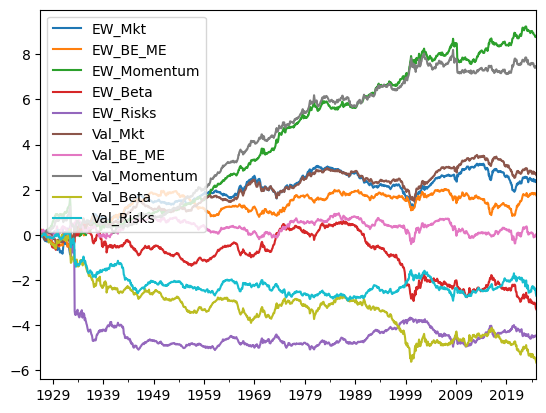

In [412]:
# we will long all strategies which had a negative outcome
# this includes:
# 1. long short market cap (value and equal weight)
# 2. long short Beta (value and equal weight)
# 3. long short idiosyncratic risk (value and equal weight)

portfolio_results.loc[:, ["EW_Mkt", "EW_Beta", "EW_Risks", "Val_Mkt", "Val_Beta", "Val_Risks"]] = -1 * portfolio_results.loc[:, ["EW_Mkt", "EW_Beta", "EW_Risks", "Val_Mkt", "Val_Beta", "Val_Risks"]]

np.log((1 + portfolio_results).cumprod()).plot()

In [385]:
# 1950 + (except for FF5 it is 1964 +)
results[0]

,Mean Return,Sharpe Ratio,Alpha 3 Factor Fama French,Alpha 4 Factor Fama French,Alpha 5 Factor Fama French
EW_Mkt,0.023079,0.170845,-0.013781,0.000616,-0.050498
EW_BE_ME,0.012385,-0.068131,-0.036858,-0.008477,-0.036834
EW_Momentum,0.122508,0.710654,0.145895,0.032615,0.138934
EW_Beta,-0.017491,-0.145634,0.028240,0.011845,-0.025971
EW_Risks,0.014734,0.143987,0.030119,0.023288,0.029517
Val_Mkt,0.030365,0.193706,-0.002333,0.013358,-0.040236
Val_BE_ME,0.004470,-0.123293,-0.046262,-0.022765,-0.050319
Val_Momentum,0.111014,0.601189,0.131512,0.004655,0.101108
Val_Beta,-0.020016,-0.201638,0.023904,0.012218,-0.028257
Val_Risks,0.008531,0.069642,0.028136,0.013448,0.022271


In [386]:
results[1] # 1990 +

,Mean Return,Sharpe Ratio,Alpha 3 Factor Fama French,Alpha 4 Factor Fama French,Alpha 5 Factor Fama French
EW_Mkt,0.011360,0.245333,-0.011251,0.005628,-0.063838
EW_BE_ME,0.013098,0.244331,-0.021977,0.001856,-0.052257
EW_Momentum,0.108601,0.432414,0.137994,0.043834,0.142228
EW_Beta,-0.069688,-0.299558,0.002945,-0.015806,-0.052466
EW_Risks,0.020981,0.101082,0.031457,0.021939,0.035527
Val_Mkt,0.016071,0.223441,-0.001110,0.015776,-0.052178
Val_BE_ME,-0.002386,0.065282,-0.032664,-0.010615,-0.065268
Val_Momentum,0.072420,0.270469,0.099599,-0.005692,0.097612
Val_Beta,-0.043993,-0.241523,0.026502,0.007439,-0.034338
Val_Risks,0.023816,0.144136,0.045359,0.021371,0.045139


In [387]:
results[2] # 2000 +

,Mean Return,Sharpe Ratio,Alpha 3 Factor Fama French,Alpha 4 Factor Fama French,Alpha 5 Factor Fama French
EW_Mkt,0.056752,0.527912,0.025545,0.035898,-0.039664
EW_BE_ME,0.039340,0.426789,-0.003577,0.012234,-0.046311
EW_Momentum,0.076601,0.257400,0.106899,0.045546,0.099293
EW_Beta,0.004102,-0.037256,0.074308,0.056800,0.017347
EW_Risks,-0.016827,-0.049027,-0.002580,-0.006311,0.005870
Val_Mkt,0.053932,0.495644,0.030334,0.040650,-0.032728
Val_BE_ME,0.029954,0.254707,-0.013772,0.000582,-0.055607
Val_Momentum,0.030457,0.086971,0.059094,-0.008455,0.045968
Val_Beta,0.025539,0.066927,0.088654,0.071408,0.019922
Val_Risks,-0.018484,-0.011106,0.005896,-0.005590,0.003550


In [ ]:
def long_short_portfolio(df, mkt_cap):
    """
    Calculates the returns of a long-short portfolio where the 5 largest companies by market cap are bought
    and the 5 smallest companies by market cap are sold, with allocations based on market weights.
    ---
    :param df: DataFrame of underlying asset returns
    :param mkt_cap: DataFrame of market cap of each company
    :return: pandas Series of returns of the long-short portfolio
    """
    portfolio_returns = []

    for i in range(len(mkt_cap) - 1):
        # Get market cap for the current period
        curren_mkt_cap = mkt_cap.iloc[i]
        
        # Sort companies by market cap
        sorted_mkt_cap = curren_mkt_cap.sort_values(ascending=False)
        
        # Select the 5 largest and 5 smallest companies
        largest_companies = sorted_mkt_cap.head(5)
        smallest_companies = sorted_mkt_cap.dropna().tail(5)
        
        # Calculate market weights
        long_weights = largest_companies / largest_companies.sum()
        short_weights = smallest_companies / smallest_companies.sum()
        

        # Get returns for the next period
        next_returns = df.iloc[i + 1]
        
        # Calculate portfolio return
        long_return = (next_returns[largest_companies.index] * long_weights).sum()
        short_return = (next_returns[smallest_companies.index] * short_weights).sum()
        portfolio_return = -1 * (long_return - short_return)
        
        if(i == 15):
            print(long_weights)
            print(short_weights)
            print(portfolio_return)
            print(long_return)

        portfolio_returns.append(portfolio_return)
    
    return pd.Series(portfolio_returns, index=mkt_cap.index[:-1])

# Example usage
# Assuming `df` is your DataFrame of returns and `mkt_cap` is your DataFrame of market caps
portfolio_returns = long_short_portfolio(df, be)
print(portfolio_returns)

Whlsl    0.415677
Books    0.171813
Toys     0.161520
Beer     0.143310
Cnstr    0.107680
Name: 1927-10-01 00:00:00, dtype: float64
Autos    0.250000
Rtail    0.219388
MedEq    0.198980
Hshld    0.183673
LabEq    0.147959
Name: 1927-10-01 00:00:00, dtype: float64
0.04732400948502918
0.016660174188440215
1926-07-01   -0.242010
1926-08-01   -0.008700
1926-09-01   -0.035847
1926-10-01    0.038917
1926-11-01    0.025030
                ...   
2024-07-01    0.037757
2024-08-01    0.007992
2024-09-01   -0.002025
2024-10-01   -0.027282
2024-11-01    0.083586
Freq: MS, Length: 1181, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:>

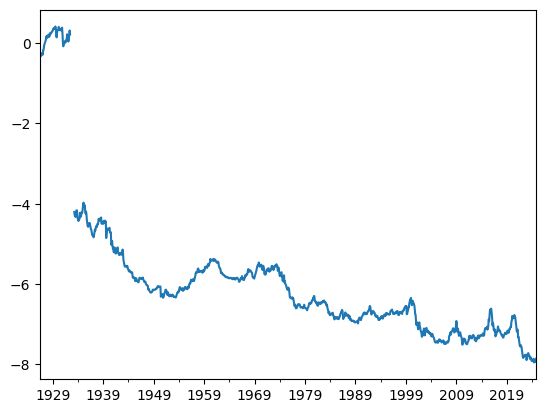

In [414]:
np.log((1 + portfolio_returns).cumprod()).plot()

In [415]:
def long_short_portfolio_btm(df, mkt_cap, be_over_me):
    """
    Calculates the returns of a long-short portfolio where the 5 highest book-to-market companies are bought
    and the 5 lowest book-to-market companies are sold, with allocations based on market weights.
    ---
    :param df: DataFrame of underlying asset returns
    :param mkt_cap: DataFrame of market cap of each company
    :param be_over_me: DataFrame of book-to-market values of each company
    :return: pandas Series of returns of the long-short portfolio
    """
    portfolio_returns = []

    for i in range(len(be_over_me) - 1):
        # Get book-to-market values for the current period
        current_be_over_me = be_over_me.iloc[i]
        
        # Sort companies by book-to-market value
        sorted_be_over_me = current_be_over_me.sort_values(ascending=False)
        
        # Select the 5 highest and 5 lowest book-to-market companies
        highest_btm_companies = sorted_be_over_me.head(5)
        lowest_btm_companies = sorted_be_over_me.dropna().tail(5)
        
        # Calculate market weights
        long_weights = mkt_cap.iloc[i][highest_btm_companies.index] / mkt_cap.iloc[i][highest_btm_companies.index].sum()
        short_weights = mkt_cap.iloc[i][lowest_btm_companies.index] / mkt_cap.iloc[i][lowest_btm_companies.index].sum()
        
        # Get returns for the next period
        next_returns = df.iloc[i + 1]
        
        # Calculate portfolio return
        long_return = (next_returns[highest_btm_companies.index] * long_weights).sum()
        short_return = (next_returns[lowest_btm_companies.index] * short_weights).sum()
        portfolio_return = long_return - short_return
        
        portfolio_returns.append(portfolio_return)
    
    return pd.Series(portfolio_returns, index=be_over_me.index[:-1])

# Example usage
# Assuming `df` is your DataFrame of returns, `mkt_cap` is your DataFrame of market caps, and `be_over_me` is your DataFrame of book-to-market values
portfolio_returns_btm = long_short_portfolio_btm(df, mkt_cap, be_over_me)
print(portfolio_returns_btm)

1926-07-01    0.127267
1926-08-01    0.028683
1926-09-01    0.035838
1926-10-01   -0.024773
1926-11-01    0.031618
                ...   
2024-07-01    0.002448
2024-08-01   -0.030766
2024-09-01    0.044764
2024-10-01    0.059037
2024-11-01   -0.071890
Freq: MS, Length: 1181, dtype: float64


<AxesSubplot:>

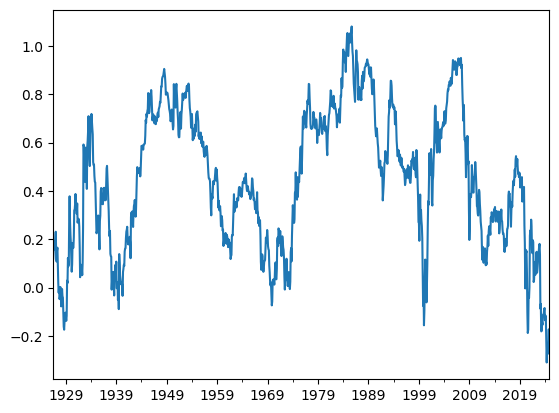

In [416]:
np.log((1 + portfolio_returns_btm).cumprod()).plot()